# How Bagging Ensembles Resample Data

In [1]:
# load required packages
import numpy as np
import pandas as pd

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Bagging flow
data = pd.DataFrame({
        'animal_type' :['dog','wolf','wolf', 'dog','dog','wolf','dog'],
        'weight' :[30,40,45,50,25,15,35],
        'anger_level':[0,10,7,8,5,3,2],
        'cuddly' : ['cuddly','not','not','not','cuddly','cuddly','cuddly']
    })

In [3]:
data

,anger_level,animal_type,cuddly,weight
0,0,dog,cuddly,30
1,10,wolf,not,40
2,7,wolf,not,45
3,8,dog,not,50
4,5,dog,cuddly,25
5,3,wolf,cuddly,15
6,2,dog,cuddly,35


In [21]:
Y = data['animal_type'].map(lambda x: 1 if x=='dog' else 0)

In [22]:
Y

0    1
1    0
2    0
3    1
4    1
5    0
6    1
Name: animal_type, dtype: int64

In [24]:
import patsy
X = patsy.dmatrix('~ cuddly + anger_level + weight', data = data, # Will end up with two columns for cuddly, intercept removal
                 return_type = 'dataframe')                       # lets there be only one cuddly column

In [25]:
X.drop('Intercept', axis=1, inplace=True) # Need to remove intercept, sklearn puts one in

In [26]:
Xmat = X.values

In [27]:
# First  Create 'base model' estimator
dtc = DecisionTreeClassifier(max_depth=None)

In [28]:
dtc.fit(Xmat,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

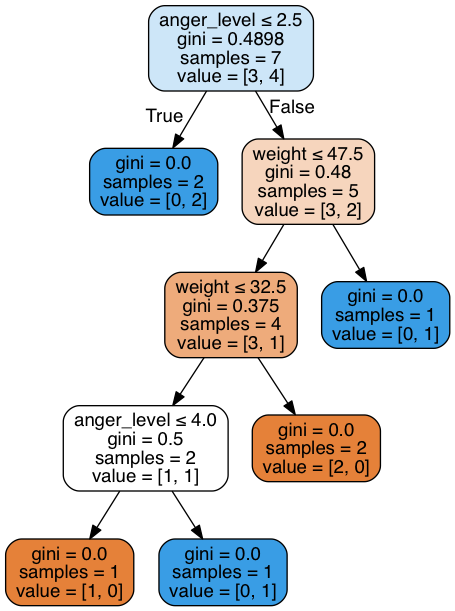

In [29]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot

dot_data = StringIO()  

export_graphviz(dtc, out_file=dot_data,
                feature_names=X.columns,
                filled=True, rounded=True,
                special_characters=True)  

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [30]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(dtc, Xmat, Y, cv=3)

print scores
print np.mean(scores)

[ 0.66666667  0.5         0.5       ]
0.555555555556


In [31]:
from sklearn.cross_validation import cross_val_score

dtc_simple = DecisionTreeClassifier(max_depth=2)

scores_simple = cross_val_score(dtc_simple, Xmat, Y, cv=3)

print scores_simple
print np.mean(scores)

[ 0.66666667  0.5         0.5       ]
0.555555555556


In [45]:
# first we create "base model" estimator
dtc = DecisionTreeClassifier(max_depth=None)

# n_estimators is the number of "base models" (copies of the dtc classifier blueprint)
# that we want to fit and then average
n_estimators=10

# max_samples tells us what fraction of the size of the original dataset
# the bootstrapped datasets are going to be.
max_samples=0.5
max_features= 0.66

#bag = BaggingClassifier(dtc)

In [57]:
rows = range(X.shape[0])
cols = range(X.shape[1])
print rows

number_of_resampled_rows = int(round(max_samples * X.shape[0]))
number_of_columns = int(round(max_features * X.shape[1]))

print "Original rows", number_of_resampled_rows
print "Original cols", number_of_columns

# Replacement resample, takes randomly from rows
# Size to take the number of samples
# For bagging replace must be true
resampled_rows = np.random.choice(rows, size=int(round(max_samples * X.shape[0])), replace=True)
resampled_cols = np.random.choice(cols, size=number_of_columns, replace=False)

print "resampled rows", resampled_rows
print "resampled cols", resampled_cols
X

[0, 1, 2, 3, 4, 5, 6]
Original rows 4
Original cols 2
resampled rows [3 6 4 5]
resampled cols [0 1]


,cuddly[T.not],anger_level,weight
0,0.0,0.0,30.0
1,1.0,10.0,40.0
2,1.0,7.0,45.0
3,1.0,8.0,50.0
4,0.0,5.0,25.0
5,0.0,3.0,15.0
6,0.0,2.0,35.0


In [38]:
X.iloc[resampled_rows, :]

,cuddly[T.not],anger_level,weight
0,0.0,0.0,30.0
4,0.0,5.0,25.0
5,0.0,3.0,15.0
2,1.0,7.0,45.0


In [60]:
from sklearn.cross_validation import KFold

In [64]:
folds = KFold(len(rows), n_folds=3)

for train_indices, test_indices in folds:
    print 'training indices', train_indices
    print 'test indices', test_indices

 training indices [3 4 5 6]
test indices [0 1 2]
training indices [0 1 2 5 6]
test indices [3 4]
training indices [0 1 2 3 4]
test indices [5 6]


In [73]:
for train_indices, test_indices in folds:
    X_train, x_test = Xmat[train_indices], Xmat[test_indices]
    Y_train, y_test = Y[train_indices], Y[test_indices]
    
    for estimator_num in range(n_estimators):
         
        print 'estimator number: ', estimator_num
        
        train_rows = range(X_train.shape[0])
        train_cols = range(X_train.shape[1])
        
        number_of_resampled_rows = int(round(max_samples * X.shape[0]))
        number_of_columns = int(round(max_features * X.shape[1]))

        resampled_rows = np.random.choice(train_rows, size=int(round(max_samples * X_train.shape[0])), 
                                          replace=True)
        resampled_cols = np.random.choice(train_cols, size=number_of_columns, 
                                          replace=False)
        
        X_train_resamp = X_train.iloc[resampled_rows,resampled_cols]
        Y_train_resamp = Y_train.iloc[resampled_rows,resampled_cols]
        
        dtc = DecisionTreeClassifier(max_depth=None)
        dtc.fit(X_train_resamp, Y_train_resamp)

estimator number:  0


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [79]:
# all the above would be the same as:

dtc = DecisionTreeClassifier(max_depth=None)
bag = BaggingClassifier(n_estimators=11, max_samples=0.5, max_features=0.66)

scores = cross_val_score(bag, X.values, Y)

print scores
print np.mean(scores)

[ 0.66666667  0.5         0.5       ]
0.555555555556
